In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
from tqdm import tqdm, trange
from utils import *
from classy import Class

cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

In [3]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [4]:
cosmos_f = open('data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [5]:
a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f) 
a_list_f.close()
print('alist', a_list)

alist [1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459]


In [135]:
weird_boxes = ['Box63_1400', 'Box35_1400', 'Box_n50_38_1400', 'Box5_1400']

leave_out_box = 'Box38_1400'

errors = {a:{} for a in a_list}
X = []
Y = []
Xlo = []
Ylo = []
z_to_a = {}
a_to_z = {}
kt = np.logspace(-3, 1, 100) # h/Mpc
for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    curr_cosmo = cosmo_params[box]
    curr_cosmo['nu_mass_ev'] = (curr_cosmo['nu_mass_ev'])**(1/8)
    curr_cosmo_values = list(curr_cosmo.values())
    
    h = curr_cosmo['H0']/100

    cosmo_dict = {
        'h': h,
        'Omega_b': curr_cosmo['ombh2'] / h**2,
        'Omega_cdm': curr_cosmo['omch2'] / h**2,
        'N_ur': 0.00641,
        'N_ncdm': 1,
        'output': 'mPk mTk',
        'z_pk': '0.0,99',
        'P_k_max_h/Mpc': 20.,
        'm_ncdm': curr_cosmo['nu_mass_ev']/3,
        'deg_ncdm': 3,
        'T_cmb': 2.7255,
        'A_s': curr_cosmo['As'] * 10**-9,
        'n_s': curr_cosmo['ns'],
        'Omega_Lambda': 0.0,
        'w0_fld': curr_cosmo['w0'],
        'wa_fld': 0.0,
        'cs2_fld': 1.0,
        'fluid_equation_of_state': "CLP"
    }

    pkclass = Class()
    pkclass.set(cosmo_dict)
    pkclass.compute()

    for a in a_list:
        z = scaleToRedshift(a)
        z_to_a[z] = a
        a_to_z[a] = z
        pk_m_lin = np.array(
            [
                pkclass.pk_lin(ki, np.array([z]))*h**3 #units of Mpc^3/h^3
                for ki in kt * h # 1 / Mpc
            ]
        )
        sigma8 = pkclass.sigma(8, z, h_units=True)
        if(leave_out_box == box):
            Xlo += [curr_cosmo_values + [a, sigma8]]
        else:
            X+= [curr_cosmo_values + [a, sigma8]]
        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
            MLE_params = pickle.load(f)
            param_values = list(MLE_params.values())
            if(leave_out_box == box):
                Ylo += [param_values]
            else:
                Y+= [param_values]
X = np.array(X)
Y = np.array(Y)
Xlo = np.array(Xlo)
Ylo = np.array(Ylo)

100%|██████████| 150/150 [00:39<00:00,  3.82it/s]


In [136]:
# ################################
# print('scaling input')
# in_scaler = Normalizer()
# in_scaler.fit(X)
# X = in_scaler.transform(X)
# Xlo = in_scaler.transform(Xlo)


# print('scaling output')
# out_scaler = Standardizer()
# out_scaler.fit(Y)
# Y = out_scaler.transform(Y)
# ##REMEMBER TO UNSCALE OUTPUT AND SAVE SCALERS#####

In [137]:
print(X.shape, Y.shape, Xlo.shape, Ylo.shape)

(2030, 10) (2030, 4) (14, 10) (14, 4)


In [138]:
X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()
n_tasks = len(Y_train[0])

In [139]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
#             [gpytorch.means.LinearMean(input_size=X_train.shape[1]) for _ in range(n_tasks)], num_tasks=n_tasks
            [gpytorch.means.ConstantMean() for _ in range(n_tasks)], num_tasks=n_tasks

        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
#             gpytorch.kernels.MaternKernel(ard_num_dims=X_train.shape[1]),
#             gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1])*gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3, ard_num_dims=X_train.shape[1])+(gpytorch.kernels.MaternKernel(ard_num_dims=X_train.shape[1]))*gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3, ard_num_dims=X_train.shape[1]),
            gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3, ard_num_dims=X_train.shape[1]),
            num_tasks=n_tasks, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = MultitaskGPModel(X_train, Y_train, likelihood)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, amsgrad=True)  # Includes GaussianLikelihood parameters

In [140]:
model.train()
likelihood.train()
training_iterations = 250
epochs_iter = tqdm(range(training_iterations), desc="Iteration")
#n_mix=8 epoch=250 looks good

for i in epochs_iter:
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
#     print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iteration: 100%|██████████| 250/250 [08:07<00:00,  1.95s/it, loss=-2.92]


In [45]:
#train some more with smaller lr to avoid disaster
model.train()
likelihood.train()
training_iterations = 250
epochs_iter = tqdm(range(training_iterations), desc="Iteration")
# Use the adam optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, amsgrad=True)  # Includes GaussianLikelihood parameters

for i in epochs_iter:
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
#     print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iteration: 100%|██████████| 250/250 [16:09<00:00,  3.88s/it, loss=-2.97]


In [141]:
from utils import *
from massfunction import *

In [142]:
# with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_lo%s.pkl"%(leave_out_box), "wb") as f:
#     pickle.dump([model,
#                  likelihood], f)

In [143]:
# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(torch.from_numpy(Xlo).float()))
    mean = predictions.mean.numpy()

In [144]:
mean.shape

(14, 4)

In [145]:
leave_out_box


'Box38_1400'

In [146]:
box =leave_out_box


In [18]:
from massfunction import *

mass_function = MassFunction(cosmo_params[box])

In [19]:
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()
print(NvM_fname)

/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/Box38_1400_NvsM.pkl


In [20]:

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(NvMs.keys()):
#     if(a != 1): #TEST
#         continue
        
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    mass_function.compute_dlnsinvdM(a)

  0%|          | 0/14 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, err = quad(dσ2dk, 0, 20/R, limit=1000)
/home/users/delon/aemulusnu_massfunction/utils.py:60: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, err = quad(dσ2dRdk, 0, 20/R, limit=1000)
100%|██████████| 14/14 [04:02<00:00, 17.30s/it]


In [21]:
box

'Box38_1400'

In [22]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

In [23]:
param_names = ['d','e','f','g']

In [147]:
predicted_params = {}
true_params = {}
for c_X, c_Y, c_mean, a in zip(Xlo, Ylo, mean, a_list):
    predicted_params[a] = c_mean
    true_params[a] = c_Y

100%|██████████| 14/14 [00:02<00:00,  5.38it/s]


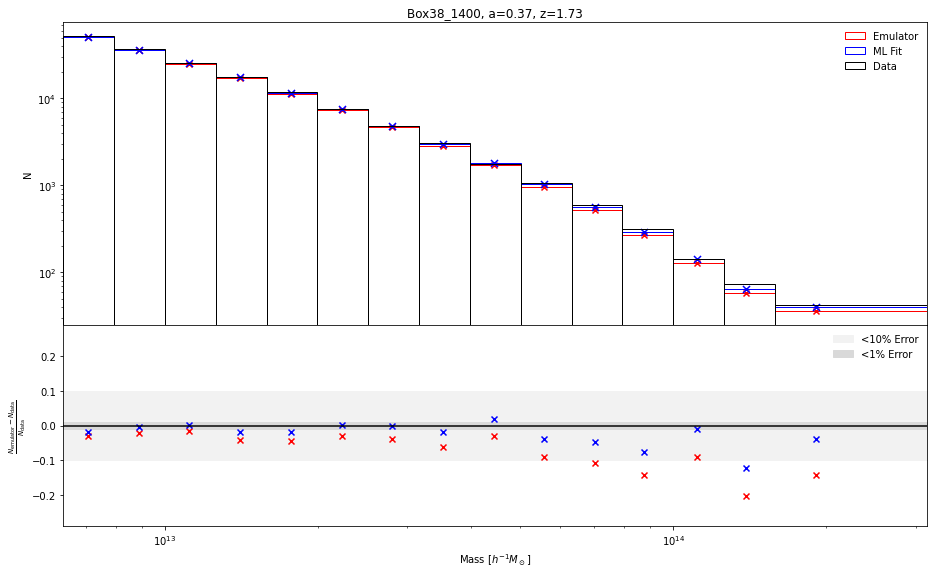

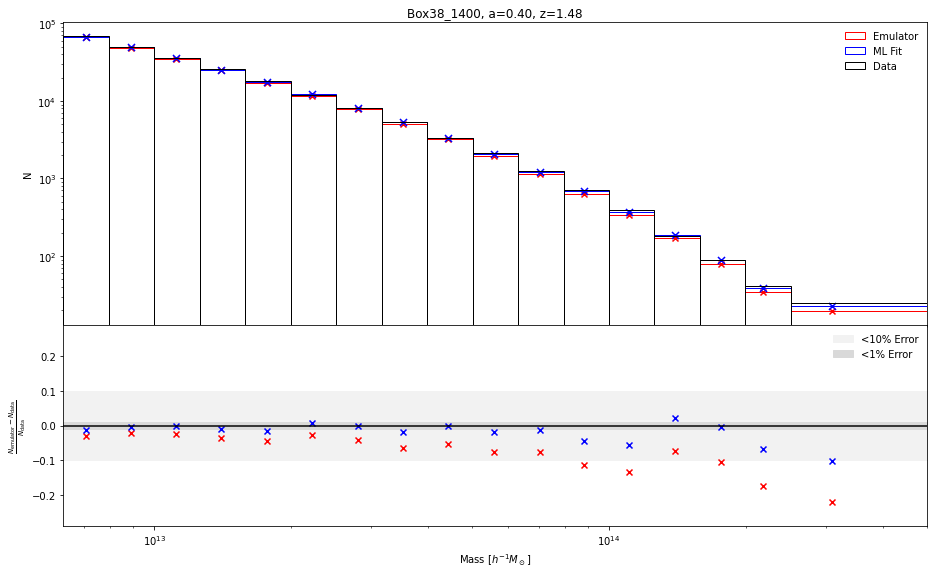

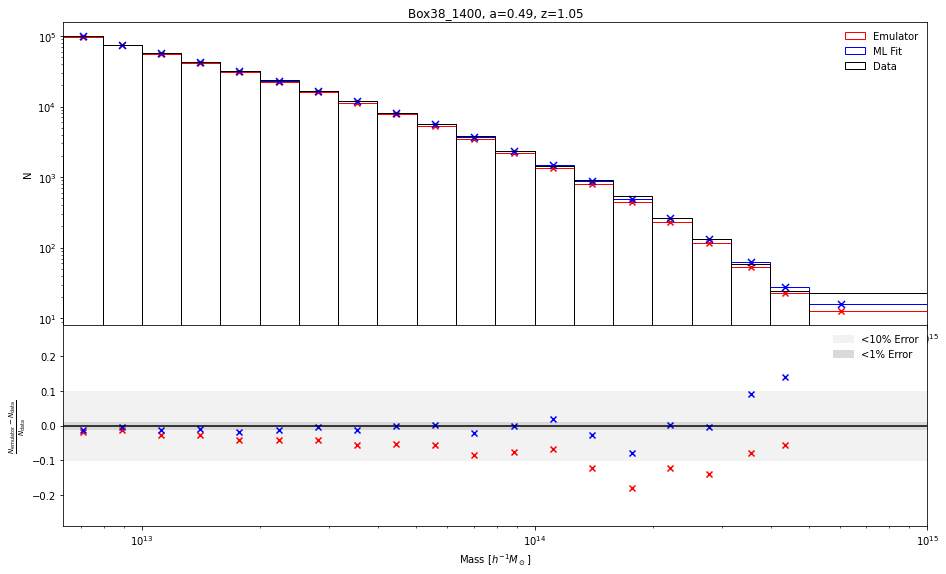

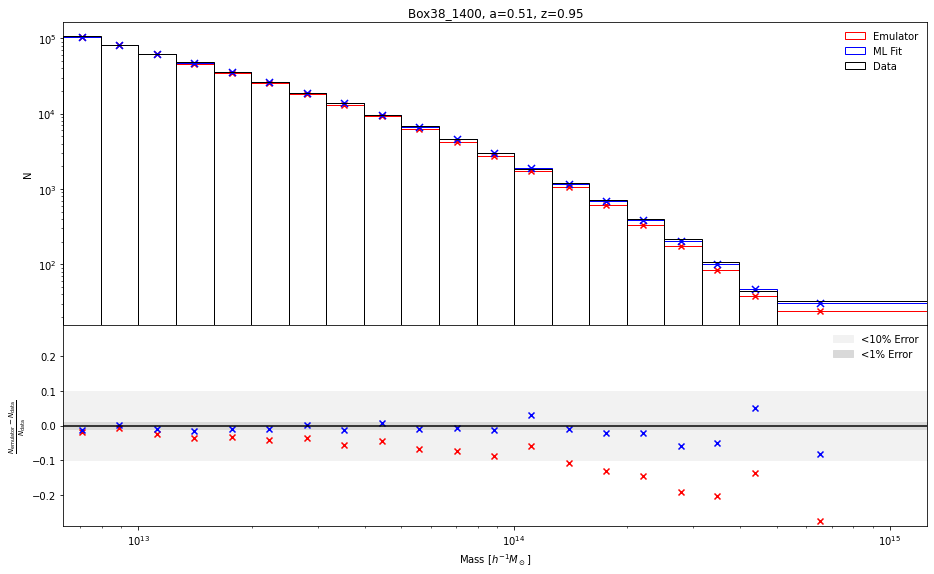

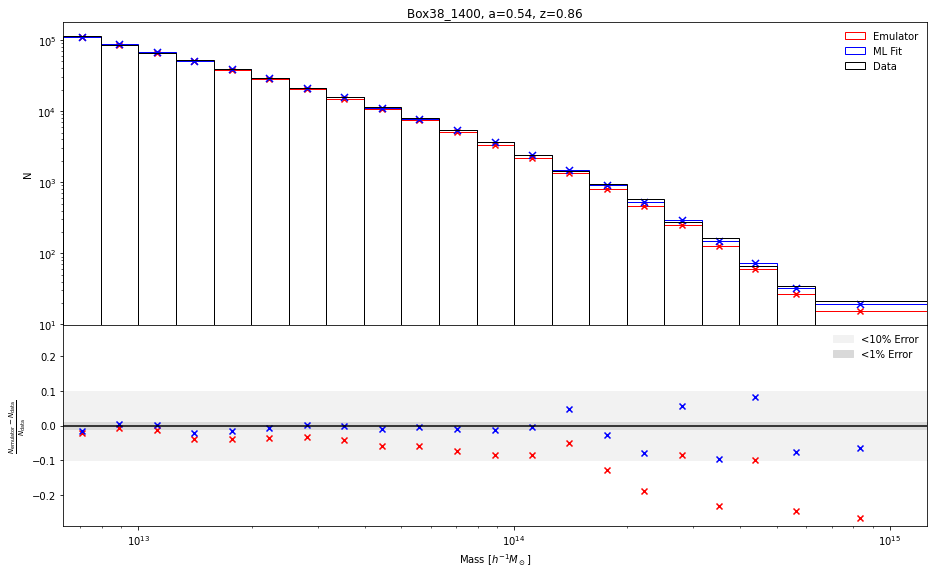

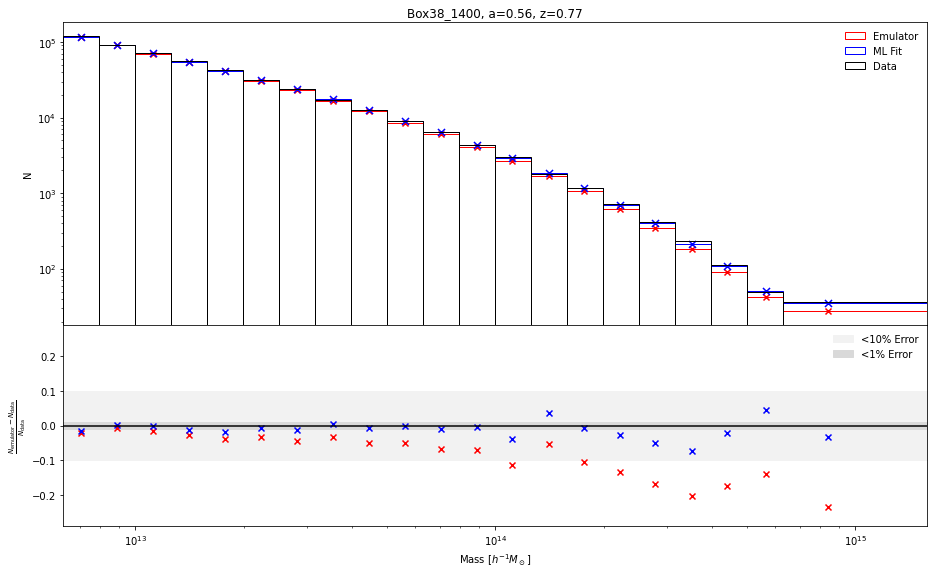

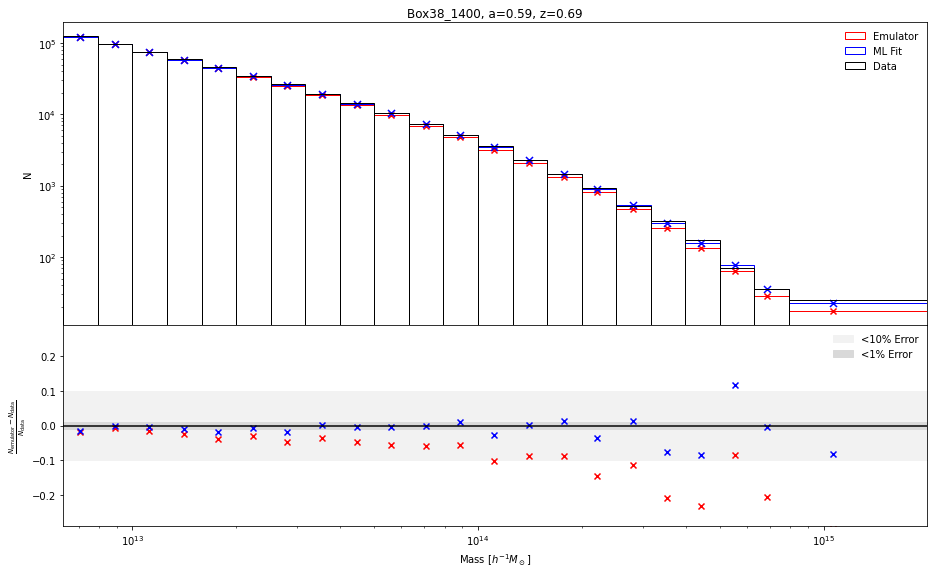

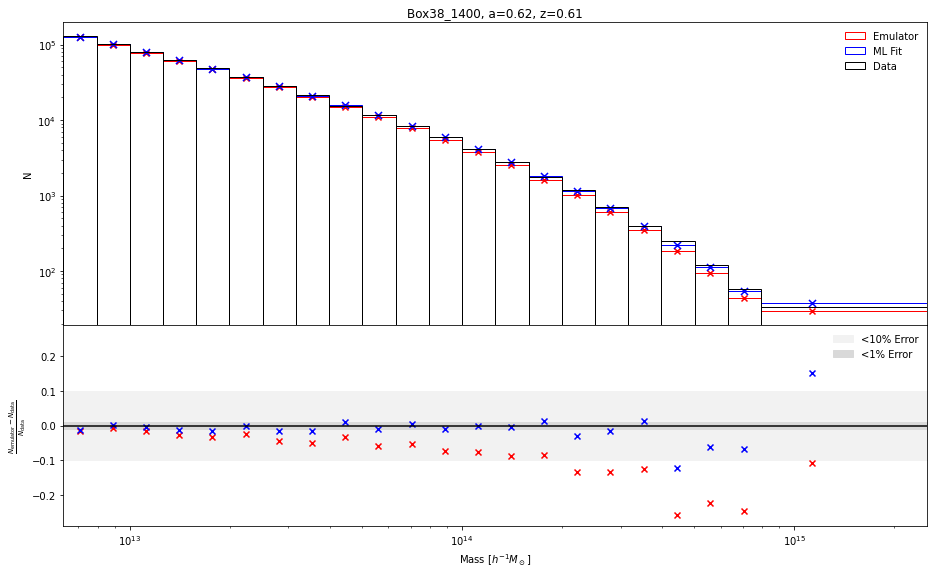

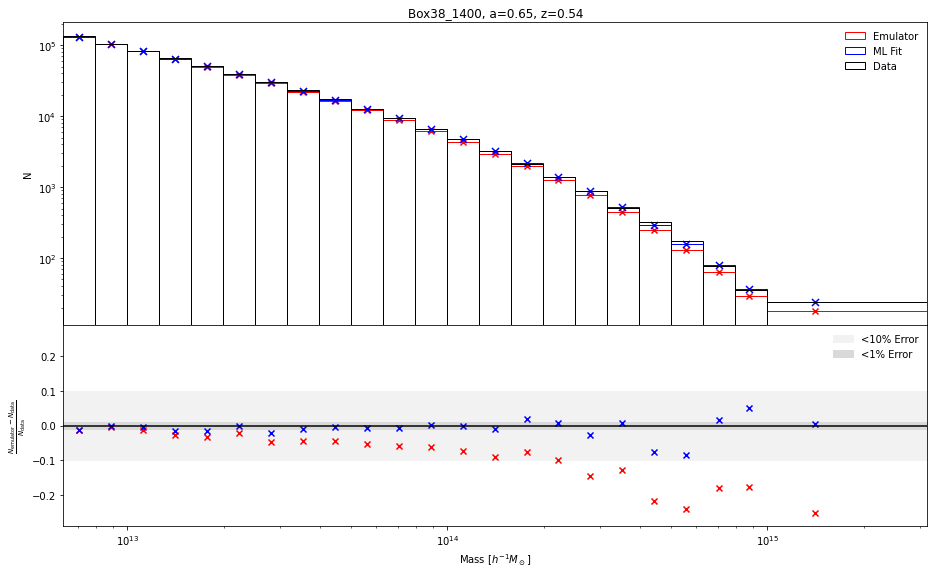

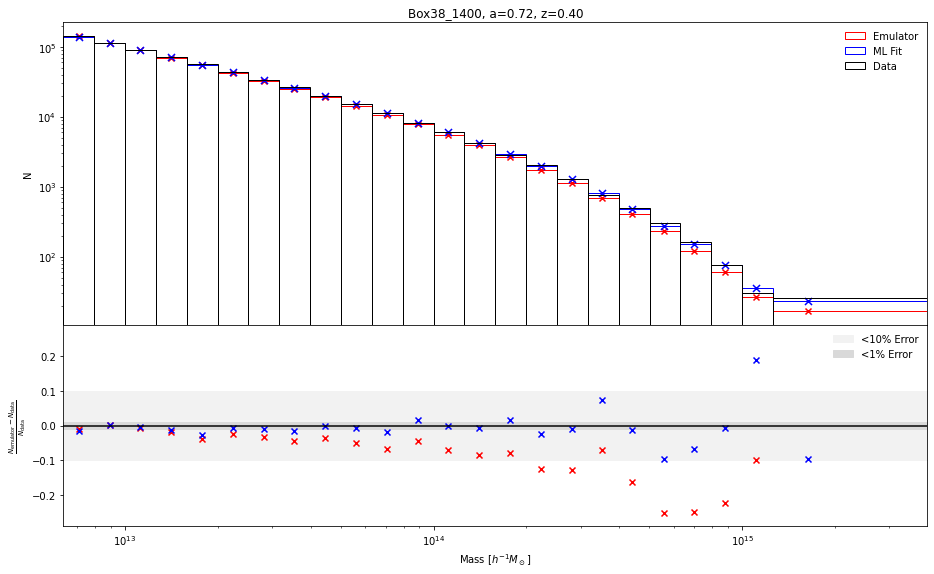

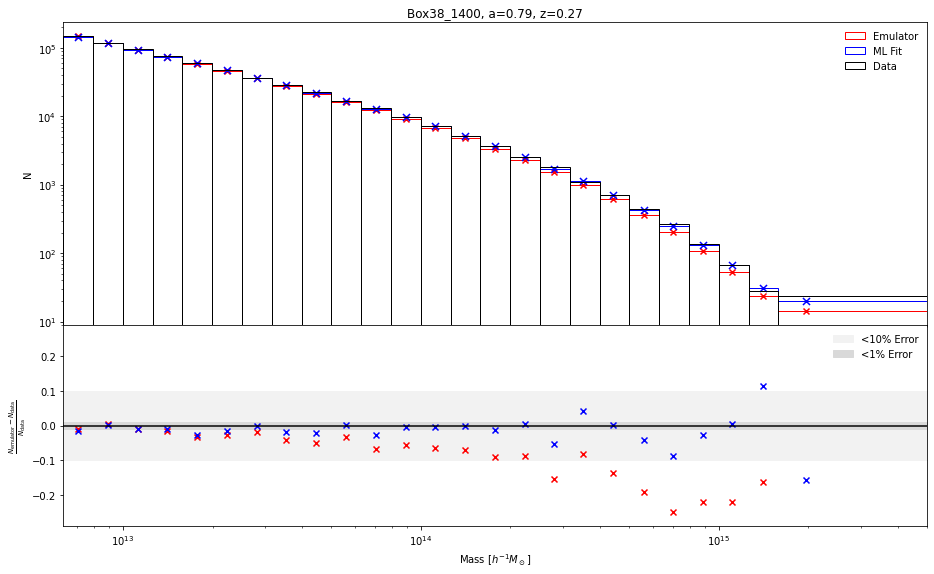

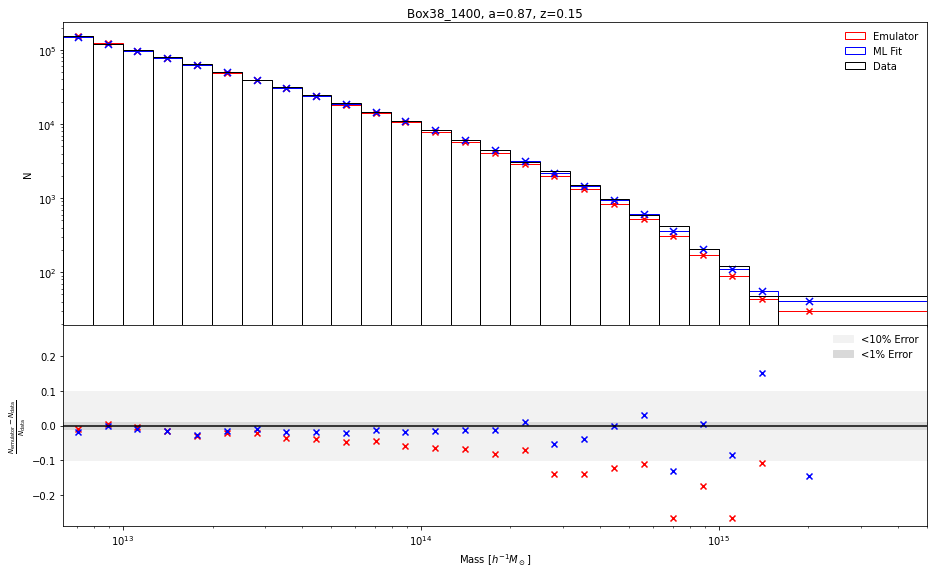

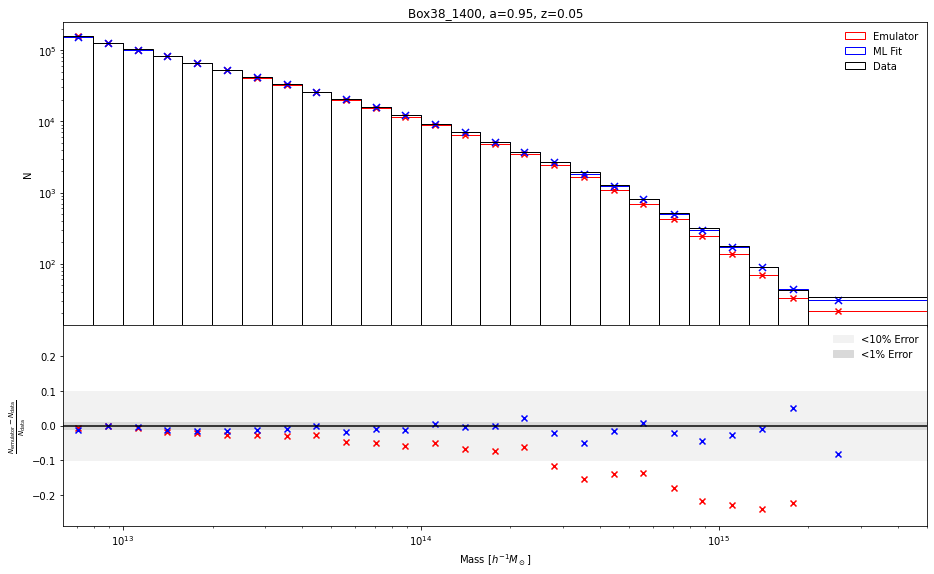

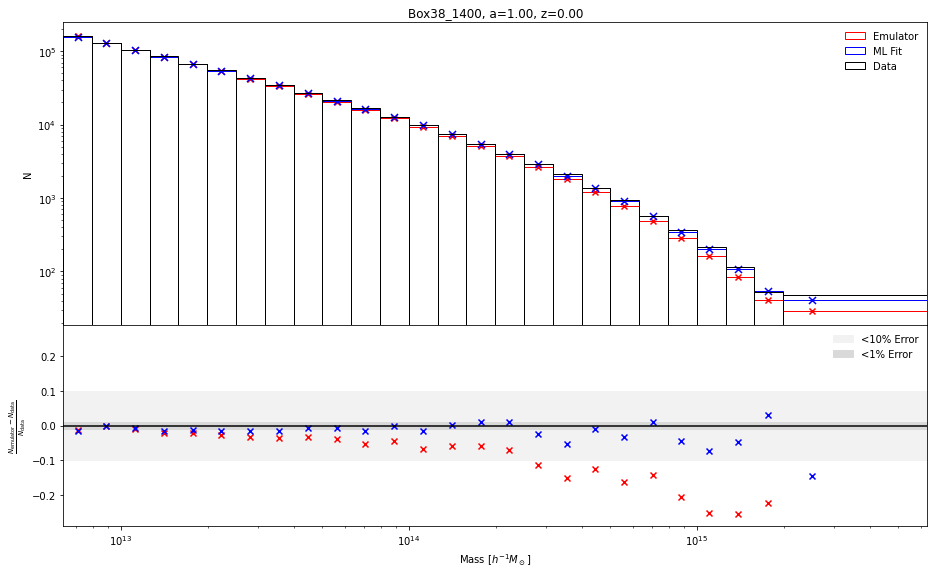

In [148]:

for a in tqdm(N_data):
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = mass_function.Pka[a]
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


    #Emulator 
    c_params = dict(zip(param_names, predicted_params[a]))
#     print(c_params)
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, **c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, marker='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='red', label='Emulator')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='red')
#     axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='red')
#     with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "wb") as f:
#         pickle.dump({'Ms':Ms, 'tinker_eval':tinker_eval_MCMC, 'N':N, 'edges':edges}, f)

    #ML Fit
    
    c_params = dict(zip(param_names, true_params[a]))
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, **c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='blue')

    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    
    
    axs[1].set_xscale('log')
    # axs[1].set_yscale('lin', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm emulator}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    axs[0].set_xlim((10**left, np.max(edges)))
    axs[1].set_xlim((10**left, np.max(edges)))
    axs[1].set_ylim((-.29, .29))
    axs[1].set_yticks([-.2, -.1, 0, .1, .2])

#     plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/emulator/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')